## Load Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# distributions
import scipy.integrate as integrate
from scipy.integrate import quad, quad_vec
from scipy.stats import invgamma
from scipy.stats import levy
from scipy.special import gamma, erfinv

import time
from datetime import datetime, timedelta

import sys
import importlib # ref: https://askubuntu.com/questions/144698/find-a-file-by-name-using-command-line
import seaborn as sns

import os

In [2]:
sys.path.append('../tools')
import tools

In [3]:
importlib.reload(tools)

<module 'tools' from '../tools/tools.py'>

## Download Data

In [4]:
df = pd.read_csv('data/apple_cleaned.csv')

In [5]:
df.head()

,date,ts,date_ts,delta_ts,bin
0,2017-01-03,09:30:00.001271,2017-01-03 09:30:00.001271,NaN,1
1,2017-01-03,09:30:00.046605,2017-01-03 09:30:00.046605,0.045334,1
2,2017-01-03,09:30:00.090184,2017-01-03 09:30:00.090184,0.043579,1
3,2017-01-03,09:30:00.090207,2017-01-03 09:30:00.090207,0.000023,1
4,2017-01-03,09:30:00.090214,2017-01-03 09:30:00.090214,0.000007,1


In [6]:
np.nanmax(df['delta_ts'])

708.5275730000001

## Estimate Spot Volatility

In [33]:
# decide whether you use sample or not
sample = False

if sample:
    data = df[df['date']< '2017-01-20']
    
else:
    data = df.copy()

In [34]:
# Plot style
widths = [1,1,1,1,2]
types = ['solid','dashed','dashdot','dotted', 'dotted']

In [35]:
gs =  [ 0.5, 1, 2, 4]

### By bins

#### Wide 0

In [36]:
ts = np.linspace(0.00001, 0.1, 6)

#### Pdf and Cdf

In [38]:
##### check the for loop, is it actually doing what it is supposed to d
#sigma_hats_ts = []
f_hats_ts = []
F_hats_ts= []

# subset the dataframe
t_g_ws = np.array(data['delta_ts'])

# for each t
for t in ts:
    
    # estimate f_hat, F_hat
    f_hats = []
    F_hats = []
    sigma_hats = []
    
    # start_time for current iteration
    start_time = time.time()
     

    # calculate f_hat
    f_hat = tools.f_hat_t(t, t_g_ws, n = len(t_g_ws))
    f_hats.append(f_hat)

    # calculate F_hat
    F_hat = tools.F_hat_t(t, t_g_ws, n = len(t_g_ws))
    F_hats.append(F_hat)
           
    
    # store the estimates
    f_hats_ts.append(f_hats)
    F_hats_ts.append(F_hats)

    # show the end time
    end_time = time.time()   
    print(f"Time : {end_time - start_time} for t = {t}")
    



Time : 275.41400504112244 for t = 1e-05
Time : 65.80079412460327 for t = 0.020008
Time : 65.1592161655426 for t = 0.04000600000000001
Time : 65.68304896354675 for t = 0.06000400000000001
Time : 66.39484071731567 for t = 0.080002
Time : 65.99669909477234 for t = 0.1


#### Spot Volatility

In [1]:
sigma_hats_gs = []

for g_i, g in zip(range(0, len(gs)), gs):
    
    sigma_hats_ts = []
    # for each t
    for i, t in zip(range(0, len(ts)),ts):
    
        # store the estimates
        f_hats = f_hats_ts[i]
        F_hats = F_hats_ts[i]
        
        sigma_hats_t = tools.sigma_hat_t(f_hats, F_hats, g)
        sigma_hats_ts.append(sigma_hats_t)
        
    sigma_hats_gs.append(sigma_hats_ts)
    
    

NameError: name 'gs' is not defined

#### Summary Stats

In [66]:
summary_stats = [np.nanmean, np.nanmedian, np.nanstd, 0.05, 0.95]

# list to store summaries
summaries = []

# for each t
for i, t in zip(range(0, len(ts)),ts):
    
    # store the estimates
    f_hats = f_hats_ts[i]
    F_hats = F_hats_ts[i]
    sigma_hats = sigma_hats_ts[i]
    
    # calculate summary stats
    f_stats = tools.estimation_summary(f_hats, summary_stats, rounding = 10)
    F_stats = tools.estimation_summary(F_hats, summary_stats, rounding = 10)
    # create a dataframe
    summary_t = pd.DataFrame([f_stats, F_stats],columns =  ['Mean', 'Median','Std', '5.0%', '95%'],
                            index = [np.tile(t, 2) , ['$\widehat{f}$', '$\widehat{F}$']])
    
    summary_t.index.set_names(['t', 'Statistics'], inplace = True)
    
    # store the summary
    summaries.append(summary_t)

    


In [67]:
pd.concat(summaries)

Mean       Median  Std         5.0%  \
t        Statistics                                                  
0.000010 $\widehat{f}$  1143.821106  1143.821106  0.0  1143.821106   
         $\widehat{F}$     0.181345     0.181345  0.0     0.181345   
0.020008 $\widehat{f}$     2.008151     2.008151  0.0     2.008151   
         $\widehat{F}$     0.679962     0.679962  0.0     0.679962   
0.040006 $\widehat{f}$     1.181164     1.181164  0.0     1.181164   
         $\widehat{F}$     0.708873     0.708873  0.0     0.708873   
0.060004 $\widehat{f}$     0.911129     0.911129  0.0     0.911129   
         $\widehat{F}$     0.729870     0.729870  0.0     0.729870   
0.080002 $\widehat{f}$     0.767233     0.767233  0.0     0.767233   
         $\widehat{F}$     0.746436     0.746436  0.0     0.746436   
0.100000 $\widehat{f}$     0.853836     0.853836  0.0     0.853836   
         $\widehat{F}$     0.760947     0.760947  0.0     0.760947   

                                95%  
t        Statistics                  
0.000010 $\widehat{f}$  1143.821106  
         $\widehat{F}$     0.181345  
0.020008 $\widehat{f}$     2.008151  
         $\widehat{F}$     0.679962  
0.040006 $\widehat{f}$     1.181164  
         $\widehat{F}$     0.708873  
0.060004 $\widehat{f}$     0.911129  
         $\widehat{F}$     0.729870  
0.080002 $\widehat{f}$     0.767233  
         $\widehat{F}$     0.746436  
0.100000 $\widehat{f}$     0.853836  
         $\widehat{F}$     0.760947

In [68]:
print(pd.concat(summaries).to_latex( caption = 'Summary Statistics of the Empirical Estimation of $\widehat{f}$ and $\widehat{F}$',
                        float_format="%.2f",
#                         formatters = {'Mean': "{:.2E}".format,
#                                       'Median': "{:.2E}".format,
#                                       'Std': "{:.2E}".format,
#                                       '5.0%': "{:.2E}".format,
#                                       '95%': "{:.2E}".format},
                        position = 'H',
                        longtable = True,
                        escape=False))

\begin{longtable}[H]{llrrrrr}
\caption{Summary Statistics of the Empirical Estimation of $\widehat{f}$ and $\widehat{F}$}\\
\toprule
         &               &    Mean &  Median &  Std &    5.0% &     95% \\
t & Statistics &         &         &      &         &         \\
\midrule
\endfirsthead
\caption[]{Summary Statistics of the Empirical Estimation of $\widehat{f}$ and $\widehat{F}$} \\
\toprule
         &               &    Mean &  Median &  Std &    5.0% &     95% \\
t & Statistics &         &         &      &         &         \\
\midrule
\endhead
\midrule
\multicolumn{7}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
0.000010 & $\widehat{f}$ & 1143.82 & 1143.82 & 0.00 & 1143.82 & 1143.82 \\
         & $\widehat{F}$ &    0.18 &    0.18 & 0.00 &    0.18 &    0.18 \\
0.020008 & $\widehat{f}$ &    2.01 &    2.01 & 0.00 &    2.01 &    2.01 \\
         & $\widehat{F}$ &    0.68 &    0.68 & 0.00 &    0.68 &    0.68 \\
0.040006 & $\widehat{f}$ &    1.18 &   

<ipython-input-68-1f51fe3585d4>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.concat(summaries).to_latex( caption = 'Summary Statistics of the Empirical Estimation of $\widehat{f}$ and $\widehat{F}$',


In [69]:
summary_stats = [np.nanmean, np.nanmedian, np.nanstd, 0.05, 0.95]
summaries = []

# Initialize gs, ts, and sigma_hats_gs variables with appropriate values

# Iterate over groups
for g_i, g in enumerate(gs):
    sigma_hats_g = sigma_hats_gs[g_i]

    # Iterate over time periods
    for i, t in enumerate(ts):
        sigma_hats = sigma_hats_g[i]

        # Calculate summary statistics
        sigma_hats_stats = tools.estimation_summary(sigma_hats, summary_stats, rounding=10)

        # Create a dataframe
        summary_t = pd.DataFrame([sigma_hats_stats],
                                 columns=['Mean', 'Median', 'Std', '5.0%', '95%'],
                                 index=pd.MultiIndex.from_tuples([(g, t, '$\widehat{\sigma}_{t}$')],
                                                                 names=['g', 't', 'Statistics']))

        summaries.append(summary_t)

In [70]:
print(pd.concat(summaries).sort_index(level = 1, sort_remaining = 0).to_latex( caption = 'Summary statistics of Empirical Estimate of Volatility with different g',
                        float_format="%.2f",
                        formatters = {'Mean': "{:.2E}".format,
                                      'Median': "{:.2E}".format,
                                      #'Bias': "{:.2E}".format,
                                      'Std': "{:.2E}".format,
                                      '5.0%': "{:.2E}".format,
                                      '95%': "{:.2E}".format},
                        position = 'H',
                        longtable = True,
                        escape=False))

\begin{longtable}[H]{lllrrrrr}
\caption{Summary statistics of Empirical Estimate of Volatility with different g}\\
\toprule
    &          &                        &     Mean &   Median &      Std &     5.0% &      95% \\
g & t & Statistics &          &          &          &          &          \\
\midrule
\endfirsthead
\caption[]{Summary statistics of Empirical Estimate of Volatility with different g} \\
\toprule
    &          &                        &     Mean &   Median &      Std &     5.0% &      95% \\
g & t & Statistics &          &          &          &          &          \\
\midrule
\endhead
\midrule
\multicolumn{8}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
0.5 & 0.000010 & $\widehat{\sigma}_{t}$ & 7.33E+02 & 7.33E+02 & 0.00E+00 & 7.33E+02 & 7.33E+02 \\
1.0 & 0.000010 & $\widehat{\sigma}_{t}$ & 2.93E+03 & 2.93E+03 & 0.00E+00 & 2.93E+03 & 2.93E+03 \\
2.0 & 0.000010 & $\widehat{\sigma}_{t}$ & 1.17E+04 & 1.17E+04 & 0.00E+00 & 1.17E+04 & 1.17E+

<ipython-input-70-24462e836325>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.concat(summaries).sort_index(level = 1, sort_remaining = 0).to_latex( caption = 'Summary statistics of Empirical Estimate of Volatility with different g',


#### Plots

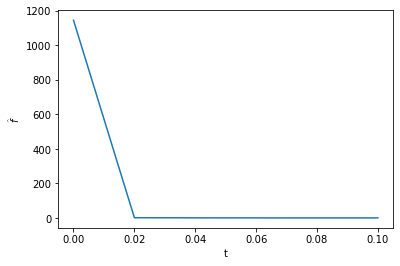

In [63]:
# make some plots
plt.plot(ts, np.mean(f_hats_ts, axis = 1))
plt.ylabel('$\widehat{f}$')
plt.xlabel('t')
#plt.legend()

plt.savefig('figures/distributions/pdf_wide_0_01', facecolor='w')
plt.show()
plt.close()


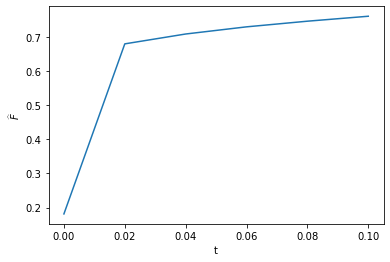

In [64]:
### Plotting F_hat
plt.plot(ts, np.mean(F_hats_ts, axis = 1))
plt.ylabel('$\widehat{F}$')
plt.xlabel('t')
#plt.legend()

plt.savefig('figures/distributions/cdf_wide_0_01', facecolor='w')
plt.show()
plt.close()




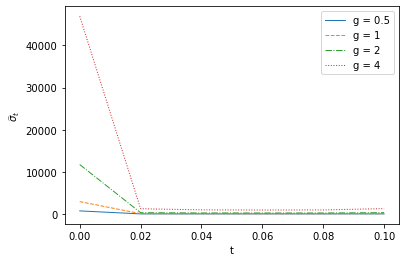

In [65]:
for g_i in range(0, len(gs)):
    
    plt.plot(ts, np.nanmean(sigma_hats_gs[g_i], axis = 1),
            label = f'g = {gs[g_i]}',
            linestyle = types[g_i],
            linewidth = widths[g_i])
    
    
plt.ylabel('$\widehat{\sigma}_{t}$')
plt.xlabel('t')
plt.legend()

plt.savefig('figures/distributions/sigma_wide_0_01', facecolor='w')
plt.show()
plt.close()